In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
from sklearn import datasets

# Visualización.
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

%matplotlib inline

## 1. Dataset

El conjunto de datos CIRCLES consiste en puntos en un plano que forman dos círculos, de aquí el nombre de "circles". Cada círculo corresponde a un grupo diferente [0, 1].

El siguiente código generará 1.000 puntos y hace un gràfico para visualizar los dos círculos (con colores diferentes para cada grupo). 

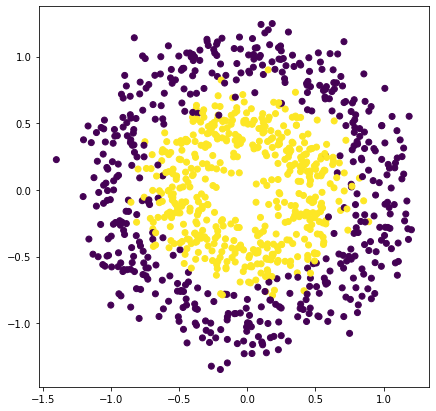

In [2]:
df = datasets.make_circles(n_samples=1000, factor=.5, noise=.15, random_state=42)
df_x = [x[0] for x in df[0]]
df_y = [x[1] for x in df[0]]
df_group = df[1]

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(df_x, df_y, c=df_group, label = "sa")

Antes de aplicar ningún modelo, tenemos que separar los datos entre el conjunto de *train* y de *test*. Siempre trabajaremos sobre el conjunto de *train* y evaluaremos los resultados en *test*.

In [3]:
random_state = 24

X_train, X_test, y_train, y_test = train_test_split(df[0], df[1], random_state=random_state, test_size = 0.2)

A lo largo del ejercicio aprenderemos a ver gráficamente las fronteras de decisión que nos devuelven los diferentes modelos. Para ello utilizaremos la función definida a continuación, que sigue los siguientes pasos:

   - Crear una _meshgrid_ con los valores mínimo y máximo de 'x' e 'y'.
   - Predecir el clasificador con los valores de la _meshgrid_.
   - Hacer un _reshape_ de los datos para tener el formato correspondiente.
  
Una vez hecho esto, ya podemos hacer el gráfico de las fronteras de decisión y añadir los puntos reales. Así veremos las áreas que el modelo considera que son de una clase y las que considera que son de otra. Al poner encima los puntos veremos si los clasifica correctamente en el área que les corresponde. También veremos las areas de indecisión, casos en los que el modelo no se inclina ni hacia una clase ni hacia otra (o si que se inclina pero no lo tiene 100% claro), estas seran blanquinosas.

In [4]:
# Vamos a crear la meshgrid con los valores mínimos y máximos de los ejes x e y
x_min, x_max = min(df_x)-0.1, max(df_x)+0.1
y_min, y_max = min(df_y)-0.1, max(df_y)+0.1 

def plot_decision_boundaries(x, y, labels, model, 
                             x_min=x_min, 
                             x_max=x_max, 
                             y_min=y_min, 
                             y_max=y_max, 
                             grid_step=0.02):
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))
    
    # Precedimos con el clasificador con los valores de la meshgrid
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]

    # Hacemos reshape para tener el formato correcto.
    Z = Z.reshape(xx.shape)

    # Seleccionamos una paleta de color.
    arr = plt.cm.coolwarm(np.arange(plt.cm.coolwarm.N))
    arr_hsv = mpl.colors.rgb_to_hsv(arr[:,0:3])
    arr_hsv[:,2] = arr_hsv[:,2] * 1.5
    arr_hsv[:,1] = arr_hsv[:,1] * .5
    arr_hsv = np.clip(arr_hsv, 0, 1)
    arr[:,0:3] = mpl.colors.hsv_to_rgb(arr_hsv) 
    my_cmap = ListedColormap(arr)
    
    # Dibujamos las fronteras de decisión.
    fig, ax = plt.subplots(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=my_cmap, shading='auto')

    # Añadimos los puntos.
    ax.scatter(x, y, c=labels, cmap='coolwarm')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.grid(False)

### 1.3. SVM

Las Support Vector Machine se fundamentan en el _Máximal Margin Classifier_, que a su vez, se basan en el concepto de hiperplano.

En un espacio p-dimensional, un hiperplano se define como un subespacio plano y afín de dimensiones p-1. El término afín significa que el subespacio no debe pasar por el origen. En un espacio de dos dimensiones, el hiperplano es un subespacio de 1 dimensión, es decir, una recta. En un espacio tridimensional, un hiperplano es un subespacio de dos dimensiones, un plano convencional. Para dimensiones p>3 no es intuitivo visualizar un hiperplano, pero el concepto de subespacio con p-1 dimensiones se mantiene.

La definición de hiperplano para casos perfectamente separables linealmente resulta en un número infinito de posibles hiperplanos, lo que hace necesario un método que permita seleccionar uno de ellos como clasificador óptimo.

La solución a este problema consiste en seleccionar como clasificador óptimo al que se conoce como _maximal margin hyperplane_ o hiperplano óptimo de separación, que se corresponde con el hiperplano que se encuentra más alejado de todas las observaciones de entrenamiento. Para obtenerlo, se debe calcular la distancia perpendicular de cada observación a un determinado hiperplano. La menor de estas distancias (conocida como margen) determina cómo de lejos está el hiperplano de las observaciones de entrenamiento. El _maximal margin hyperplane_ se define como el hiperplano que consigue un mayor margen, es decir, que la distancia mínima entre el hiperplano y las observaciones es lo más grande posible. Aunque esta idea suena razonable, no es posible aplicarla, ya que habría infinitos hiperplanos contra los que medir las distancias. En su lugar, se recurre a métodos de optimización.

El proceso de optimización tiene la peculiaridad de que sólo las observaciones que se encuentran justo al margen o que lo violan influyen sobre el hiperplano. A estas observaciones se les conoce como vectores soporte (_vectors suport_) y son las que definen el clasificador obtenido.

#### Los _kernels_ en SVM

Hay veces en que no hay manera de encontrar un hiperplano que permita separar dos clases. En estos casos decimos que las clases no son linealmente separables. Para resolver este problema podemos utilizar el truco del núcleo .

El truco del núcleo (_kernel trick_) consiste en utilizar una dimensión nueva en la que podamos encontrar un hiperplano para separar las clases. Se puede ver un un ejemplo en: https://www.youtube.com/watch?v=OdlNM96sHio

Al igual que en el algoritmo visto anteriormente (KNN), las SVM también dependen de varios hiperparámetros. 

En este caso intentaremos optimizar dos hiperparámetros:

  - C: es la regularización, es decir, el valor de penalización de los errores en la clasificación. Indica el compromiso entre obtener el hiperplano con el margen más grande posible y clasificar el máximo número de ejemplos correctamente. Probaremos los valores: 0.01, 0.1, 1, 10, 50, 100 y 200.
  
  - gama: coeficiente que multiplica la distancia entre dos puntos en el kernel radial. Para decirlo a "grosso modo", cuanto más pequeño es gama, más influencia tienen dos puntos cercanos. Probaremos los valores: 0.001, 0.01, 0.1, 1 y 10.
  
Al igual que en el caso anterior, para validar el rendimiento del algoritmo con cada combinación de hiperparámetros utilizaremos validación cruzada (_cross-validation_) con 4 particiones estratificadas.

In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
svc_model = SVC()


c_range = [0.01, 0.1, 1, 10, 50, 100, 200]
gama_range = [0.001, 0.01, 0.1, 1, 10]

param_grid = dict(C=c_range, gamma=gama_range)

grid = GridSearchCV(svc_model, param_grid, cv=4, scoring='accuracy', verbose=1)

grid_search=grid.fit(X_train, y_train)

Fitting 4 folds for each of 35 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    0.9s finished


In [8]:
grid_search.best_params_

{'C': 0.1, 'gamma': 1}

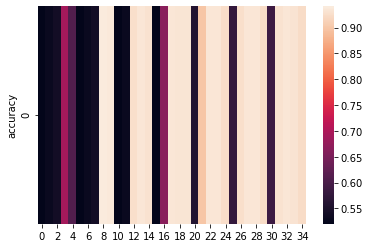

In [9]:
sns.heatmap([grid_search.cv_results_['mean_test_score']])
plt.ylabel('accuracy')
plt.show()

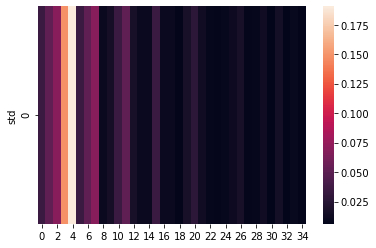

In [10]:
sns.heatmap([grid_search.cv_results_['std_test_score']])
plt.ylabel('std')
plt.show()

En el primer mapa de calor se observan los promedios de las precisiones cuando `C` y `gamma` toman los valores de [0.01, 0.1, 1, 10, 50, 100, 200] y [0.001, 0.01, 0.1, 1, 10] respectivamente. Los mejores resultados se obtuvieron con los índices 8, 12, 15, 18, entre otros. Sin embargo, para el 2do mapa de calor se visualiza las desviaciones estándares de los promedios anteriores. El mejor n_neighbors está en la posición 8, debido al resultado inferior de la desviación estándar en relación con los demás índices.

In [11]:
svc_model = SVC(C=0.1, gamma= 1, probability=True)
svc_model.fit(X_train, y_train)
y_pred = svc_model.predict(X_test)

In [12]:
confusion_matrix(y_test, y_pred)

array([[95,  4],
       [ 4, 97]], dtype=int64)

In [13]:
accuracy = accuracy_score(y_test,y_pred)
accuracy

0.96

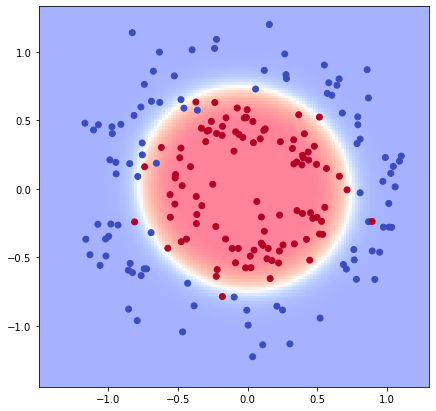

In [14]:
plot_decision_boundaries(X_test[:, 0], X_test[:, 1], y_test, svc_model, 
                             x_min=x_min, 
                             x_max=x_max, 
                             y_min=y_min, 
                             y_max=y_max, 
                             grid_step=0.02)

En el primer mapa de calor se observan los promedios de las precisiones cuando `C` y `gamma` toman los valores de [0.01, 0.1, 1, 10, 50, 100, 200] y [0.001, 0.01, 0.1, 1, 10] respectivamente. Los mejores resultados se obtuvieron en los índices 8, 12, 15, 18, entre otros. Sin embargo, para el 2do mapa de calor se visualiza las desviaciones estándares de los promedios anteriores. El mejor n_neighbors está en la posición 8, debido al resultado inferior de la desviación estándar en relación con los demás índices.

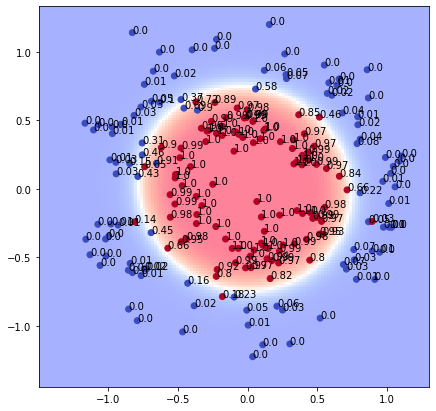

In [15]:
plot_decision_boundaries(X_test[:, 0], X_test[:, 1], y_test, svc_model, 
                             x_min=x_min, 
                             x_max=x_max, 
                             y_min=y_min, 
                             y_max=y_max, 
                             grid_step=0.02)

proba = svc_model.predict_proba(X_test)[:,1]
for x, y, prob in zip(X_test[:, 0], X_test[:, 1], proba):
    plt.text(x,y, round(prob, 2))